# Multi-step Time Series Forecasting with Long Short-Term Memory Networks in Python
The Long Short-Term Memory network or LSTM is a recurrent neural network that can learn and forecast long sequences.

A benefit of LSTMs in addition to learning long sequences is that they can learn to make a one-shot multi-step forecast which may be useful for time series forecasting.

A difficulty with LSTMs is that they can be tricky to configure and it can require a lot of preparation to get the data in the right format for learning.

In this tutorial, you will discover how you can develop an LSTM for multi-step time series forecasting in Python with Keras.

After completing this tutorial, you will know:

* How to prepare data for multi-step time series forecasting.
* How to develop an LSTM model for multi-step time series forecasting.
* How to evaluate a multi-step time series forecast.

Let’s get started.

## Tutorial Overview
This tutorial is broken down into 4 parts; they are:

1. Shampoo Sales Dataset
2. Data Preparation and Model Evaluation
3. Persistence Model
4. Multi-Step LSTM

## Shampoo Sales Dataset
This dataset describes the monthly number of sales of shampoo over a 3-year period.

The units are a sales count and there are 36 observations. The original dataset is credited to Makridakis, Wheelwright, and Hyndman (1998).

[You can download and learn more about the dataset here](https://datamarket.com/data/set/22r0/sales-of-shampoo-over-a-three-year-period#!ds=22r0).

The example below loads and creates a plot of the loaded dataset.

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64


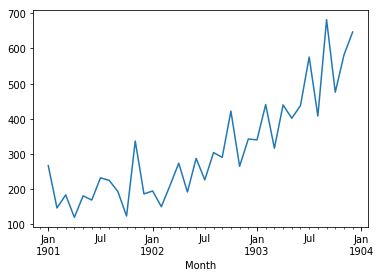

In [2]:
# load and plot dataset
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
%matplotlib inline
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# summarize first few rows
print(series.head())
# line plot
series.plot()
pyplot.show()

Running the example loads the dataset as a Pandas Series and prints the first 5 rows. A line plot of the series is then created showing a clear increasing trend.

Next, we will take a look at the model configuration and test harness used in the experiment.

## Data Preparation and Model Evaluation
This section describes data preparation and model evaluation used in this tutorial

### Data Split
We will split the Shampoo Sales dataset into two parts: a training and a test set.

The first two years of data will be taken for the training dataset and the remaining one year of data will be used for the test set.

Models will be developed using the training dataset and will make predictions on the test dataset.

For reference, the last 12 months of observations are as follows:

In [ ]:
"3-01",339.7
"3-02",440.4
"3-03",315.9
"3-04",439.3
"3-05",401.3
"3-06",437.4
"3-07",575.5
"3-08",407.6
"3-09",682.0
"3-10",475.3
"3-11",581.3
"3-12",646.9

### Multi-Step Forecast
We will contrive a multi-step forecast.

For a given month in the final 12 months of the dataset, we will be required to make a 3-month forecast.

That is given historical observations (t-1, t-2, … t-n) forecast t, t+1 and t+2.

Specifically, from December in year 2, we must forecast January, February and March. From January, we must forecast February, March and April. All the way to an October, November, December forecast from September in year 3.

A total of 10 3-month forecasts are required, as follows:

In [ ]:
Dec,	Jan, Feb, Mar
Jan,	Feb, Mar, Apr
Feb,	Mar, Apr, May
Mar,	Apr, May, Jun
Apr, 	May, Jun, Jul
May,	Jun, Jul, Aug
Jun,	Jul, Aug, Sep
Jul,	Aug, Sep, Oct
Aug,	Sep, Oct, Nov
Sep,	Oct, Nov, Dec

### Model Evaluation
A rolling-forecast scenario will be used, also called walk-forward model validation.

Each time step of the test dataset will be walked one at a time. A model will be used to make a forecast for the time step, then the actual expected value for the next month from the test set will be taken and made available to the model for the forecast on the next time step.

This mimics a real-world scenario where new Shampoo Sales observations would be available each month and used in the forecasting of the following month.

This will be simulated by the structure of the train and test datasets.

All forecasts on the test dataset will be collected and an error score calculated to summarize the skill of the model for each of the forecast time steps. The root mean squared error (RMSE) will be used as it punishes large errors and results in a score that is in the same units as the forecast data, namely monthly shampoo sales.

## Persistence Model
A good baseline for time series forecasting is the persistence model.

This is a forecasting model where the last observation is persisted forward. Because of its simplicity, it is often called the naive forecast.

### Prepare Data
The first step is to transform the data from a series into a supervised learning problem.

That is to go from a list of numbers to a list of input and output patterns. We can achieve this using a pre-prepared function called *series_to_supervised()*.

The function is listed below.

In [ ]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

The function can be called by passing in the loaded series values an *n_in* value of 1 and an *n_out* value of 3; for example:

In [ ]:
supervised = series_to_supervised(raw_values, 1, 3)

Next, we can split the supervised learning dataset into training and test sets.

We know that in this form, the last 10 rows contain data for the final year. These rows comprise the test set and the rest of the data makes up the training dataset.

We can put all of this together in a new function that takes the loaded series and some parameters and returns a train and test set ready for modeling.

In [ ]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	raw_values = raw_values.reshape(len(raw_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(raw_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return train, test

We can test this with the Shampoo dataset. The complete example is listed below.

In [3]:
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from pandas import datetime
 
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	raw_values = raw_values.reshape(len(raw_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(raw_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return train, test
 
# load dataset
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# configure
n_lag = 1
n_seq = 3
n_test = 10
# prepare data
train, test = prepare_data(series, n_test, n_lag, n_seq)
print(test)
print('Train: %s, Test: %s' % (train.shape, test.shape))

[[342.3 339.7 440.4 315.9]
 [339.7 440.4 315.9 439.3]
 [440.4 315.9 439.3 401.3]
 [315.9 439.3 401.3 437.4]
 [439.3 401.3 437.4 575.5]
 [401.3 437.4 575.5 407.6]
 [437.4 575.5 407.6 682. ]
 [575.5 407.6 682.  475.3]
 [407.6 682.  475.3 581.3]
 [682.  475.3 581.3 646.9]]
Train: (23, 4), Test: (10, 4)


Running the example first prints the entire test dataset, which is the last 10 rows. The shape and size of the train test datasets is also printed.

We can see the single input value (first column) on the first row of the test dataset matches the observation in the shampoo-sales for December in the 2nd year:

In [ ]:
"2-12",342.3

We can also see that each row contains 4 columns for the 1 input and 3 output values in each observation.

### Make Forecasts
The next step is to make persistence forecasts.

We can implement the persistence forecast easily in a function named persistence() that takes the last observation and the number of forecast steps to persist. This function returns an array containing the forecast.

In [ ]:
# make a persistence forecast
def persistence(last_ob, n_seq):
	return [last_ob for i in range(n_seq)]

We can then call this function for each time step in the test dataset from December in year 2 to September in year 3.

Below is a function *make_forecasts()* that does this and takes the train, test, and configuration for the dataset as arguments and returns a list of forecasts.

In [ ]:
# evaluate the persistence model
def make_forecasts(train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = persistence(X[-1], n_seq)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

We can call this function as follows:

In [ ]:
forecasts = make_forecasts(train, test, 1, 3)

### Evaluate Forecasts
The final step is to evaluate the forecasts.

We can do that by calculating the RMSE for each time step of the multi-step forecast, in this case giving us 3 RMSE scores. The function below, *evaluate_forecasts()*, calculates and prints the RMSE for each forecasted time step.

In [ ]:
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = test[:,(n_lag+i)]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

We can call it as follows:

In [ ]:
evaluate_forecasts(test, forecasts, 1, 3)

It is also helpful to plot the forecasts in the context of the original dataset to get an idea of how the RMSE scores relate to the problem in context.

We can first plot the entire Shampoo dataset, then plot each forecast as a red line. The function *plot_forecasts()* below will create and show this plot.

In [ ]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i
		off_e = off_s + len(forecasts[i])
		xaxis = [x for x in range(off_s, off_e)]
		pyplot.plot(xaxis, forecasts[i], color='red')
	# show the plot
	pyplot.show()

We can call the function as follows. Note that the number of observations held back on the test set is 12 for the 12 months, as opposed to 10 for the 10 supervised learning input/output patterns as was used above.

In [ ]:
# plot forecasts
plot_forecasts(series, forecasts, 12)

We can make the plot better by connecting the persisted forecast to the actual persisted value in the original dataset.

This will require adding the last observed value to the front of the forecast. Below is an updated version of the *plot_forecasts()* function with this improvement.

In [ ]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - 12 + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

### Complete Example
We can put all of these pieces together.

The complete code example for the multi-step persistence forecast is listed below.

t+1 RMSE: 144.535304
t+2 RMSE: 86.479905
t+3 RMSE: 121.149168


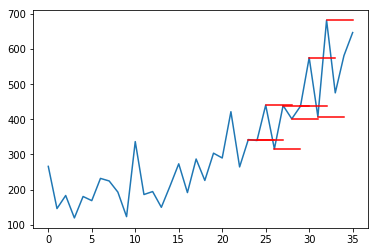

In [4]:
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
%matplotlib inline
 
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	raw_values = raw_values.reshape(len(raw_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(raw_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return train, test
 
# make a persistence forecast
def persistence(last_ob, n_seq):
	return [last_ob for i in range(n_seq)]
 
# evaluate the persistence model
def make_forecasts(train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = persistence(X[-1], n_seq)
		# store the forecast
		forecasts.append(forecast)
	return forecasts
 
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = test[:,(n_lag+i)]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))
 
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()
 
# load dataset
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# configure
n_lag = 1
n_seq = 3
n_test = 10
# prepare data
train, test = prepare_data(series, n_test, n_lag, n_seq)
# make forecasts
forecasts = make_forecasts(train, test, n_lag, n_seq)
# evaluate forecasts
evaluate_forecasts(test, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)

Running the example first prints the RMSE for each of the forecasted time steps.

This gives us a baseline of performance on each time step that we would expect the LSTM to outperform.

The plot of the original time series with the multi-step persistence forecasts is also created. The lines connect to the appropriate input value for each forecast.

This context shows how naive the persistence forecasts actually are.

## Multi-Step LSTM Network
In this section, we will use the persistence example as a starting point and look at the changes needed to fit an LSTM to the training data and make multi-step forecasts for the test dataset.

### Prepare Data
The data must be prepared before we can use it to train an LSTM.

Specifically, two additional changes are required:

1. **Stationary**. The data shows an increasing trend that must be removed by differencing.
2. **Scale**. The scale of the data must be reduced to values between -1 and 1, the activation function of the LSTM units.

We can introduce a function to make the data stationary called *difference()*. This will transform the series of values into a series of differences, a simpler representation to work with.

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

We can use the *MinMaxScaler* from the sklearn library to scale the data.

Putting this together, we can update the *prepare_data()* function to first difference the data and rescale it, then perform the transform into a supervised learning problem and train test sets as we did before with the persistence example.

The function now returns a scaler in addition to the train and test datasets.

In [ ]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

We can call this function as follows:

In [ ]:
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

### Fit LSTM Network
Next, we need to fit an LSTM network model to the training data.

This first requires that the training dataset be transformed from a 2D array [*samples, features*] to a 3D array [*samples, timesteps, features*]. We will fix time steps at 1, so this change is straightforward.

Next, we need to design an LSTM network. We will use a simple structure with 1 hidden layer with 1 LSTM unit, then an output layer with linear activation and 3 output values. The network will use a mean squared error loss function and the efficient ADAM optimization algorithm.

The LSTM is stateful; this means that we have to manually reset the state of the network at the end of each training epoch. The network will be fit for 1500 epochs.

The same batch size must be used for training and prediction, and we require predictions to be made at each time step of the test dataset. This means that a batch size of 1 must be used. A batch size of 1 is also called online learning as the network weights will be updated during training after each training pattern (as opposed to mini batch or batch updates).

We can put all of this together in a function called *fit_lstm()*. The function takes a number of key parameters that can be used to tune the network later and the function returns a fit LSTM model ready for forecasting.

In [ ]:
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit network
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

The function can be called as follows:

In [ ]:
# fit model
model = fit_lstm(train, 1, 3, 1, 1500, 1)

The configuration of the network was not tuned; try different parameters if you like.

Report your findings in the comments below. I’d love to see what you can get.

### Make LSTM Forecasts
The next step is to use the fit LSTM network to make forecasts.

A single forecast can be made with the fit LSTM network by calling *model.predict()*. Again, the data must be formatted into a 3D array with the format [*samples, timesteps, features*].

We can wrap this up into a function called *forecast_lstm()*.

In [ ]:
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

We can call this function from the *make_forecasts()* function and update it to accept the model as an argument. The updated version is listed below.

In [ ]:
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

This updated version of the *make_forecasts()* function can be called as follows:

In [ ]:
# make forecasts
forecasts = make_forecasts(model, 1, train, test, 1, 3)

### Invert Transforms
After the forecasts have been made, we need to invert the transforms to return the values back into the original scale.

This is needed so that we can calculate error scores and plots that are comparable with other models, like the persistence forecast above.

We can invert the scale of the forecasts directly using the *MinMaxScaler* object that offers an *inverse_transform()* function.

We can invert the differencing by adding the value of the last observation (prior months’ shampoo sales) to the first forecasted value, then propagating the value down the forecast.

This is a little fiddly; we can wrap up the behavior in a function name *inverse_difference()* that takes the last observed value prior to the forecast and the forecast as arguments and returns the inverted forecast.

In [ ]:
# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

Putting this together, we can create an *inverse_transform()* function that works through each forecast, first inverting the scale and then inverting the differences, returning forecasts to their original scale.

In [ ]:
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

We can call this function with the forecasts as follows:

In [ ]:
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)

We can also invert the transforms on the output part test dataset so that we can correctly calculate the RMSE scores, as follows:

In [ ]:
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)

We can also simplify the calculation of RMSE scores to expect the test data to only contain the output values, as follows:

In [ ]:
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

### Complete Example
We can tie all of these pieces together and fit an LSTM network to the multi-step time series forecasting problem.

The complete code listing is provided below.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


t+1 RMSE: 98.369191
t+2 RMSE: 87.439774
t+3 RMSE: 109.484675


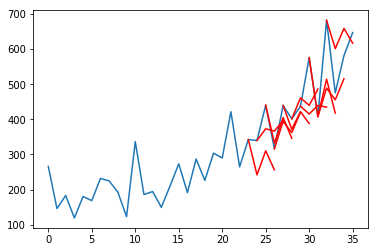

In [5]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
%matplotlib inline
 
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test
 
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit network
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model
 
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]
 
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts
 
# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted
 
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted
 
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))
 
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()
 
# load dataset
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# configure
n_lag = 1
n_seq = 3
n_test = 10
n_epochs = 1500
n_batch = 1
n_neurons = 1
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)

Running the example first prints the RMSE for each of the forecasted time steps.

We can see that the scores at each forecasted time step are better, in some cases much better, than the persistence forecast.

This shows that the configured LSTM does have skill on the problem.

It is interesting to note that the RMSE does not become progressively worse with the length of the forecast horizon, as would be expected. This is marked by the fact that the t+2 appears easier to forecast than t+1. This may be because the downward tick is easier to predict than the upward tick noted in the series (this could be confirmed with more in-depth analysis of the results).

A line plot of the series (blue) with the forecasts (red) is also created.

The plot shows that although the skill of the model is better, some of the forecasts are not very good and that there is plenty of room for improvement.

## Extensions
There are some extensions you may consider if you are looking to push beyond this tutorial.

* **Update LSTM**. Change the example to refit or update the LSTM as new data is made available. A 10s of training epochs should be sufficient to retrain with a new observation.
* **Tune the LSTM**. Grid search some of the LSTM parameters used in the tutorial, such as number of epochs, number of neurons, and number of layers to see if you can further lift performance.
* **Seq2Seq**. Use the encoder-decoder paradigm for LSTMs to forecast each sequence to see if this offers any benefit.
* **Time Horizon**. Experiment with forecasting different time horizons and see how the behavior of the network varies at different lead times.

## Summary
In this tutorial, you discovered how to develop LSTM networks for multi-step time series forecasting.

Specifically, you learned:

* How to develop a persistence model for multi-step time series forecasting.
* How to develop an LSTM network for multi-step time series forecasting.
* How to evaluate and plot the results from multi-step time series forecasting.